In [1]:
"""
Forcing Matching Number Calculator for m-Generalized Fullerene Graphs F(m,k)

This script computes the forcing number for the vertical perfect matching (M_v)
of generalized fullerene graphs F(m,k). It utilizes a backtracking algorithm
optimized with early termination and graph reduction techniques.

Reference:
    "The Forcing Matching Number of m-Generalized Fullerene Graphs"
    Authors: P. Asadzadeh, A. Behmaram, T. Doslic (2026)

Dependencies:
    networkx, numpy
"""

import networkx as nx
import numpy as np
from itertools import combinations
import time
import csv
import multiprocessing
from typing import List, Tuple, Set, Optional, Any

# ==============================================================================
# SECTION 1: Graph Construction and Core Analysis Functions
# ==============================================================================

def create_fmk_graph(m: int, k: int) -> nx.Graph:
    """
    Constructs the m-generalized fullerene graph F(m,k).

    Parameters:
        m (int): The cap width parameter (must be >= 3).
        k (int): The cylindrical length parameter (number of hexagonal layers).

    Returns:
        nx.Graph: The constructed graph instance with tagged edges.
    """
    if m < 3:
        raise ValueError("Parameter 'm' must be at least 3.")

    G = nx.Graph()
    n_vertices = 2 * m * (k + 2)
    G.add_nodes_from(range(n_vertices))

    # Define layer structure
    # Layer 0: Cap (size m)
    # Layers 1 to k+1: Barrel (size 2m)
    # Layer k+2: Cap (size m)
    layer_sizes = [m] + [2 * m for _ in range(k + 1)] + [m]
    layer_starts = np.cumsum([0] + layer_sizes)[:-1]

    # 1. Add Intra-layer edges (Horizontal)
    # Caps (L_0 and L_{k+2})
    for r in [0, k + 2]:
        start, size = layer_starts[r], layer_sizes[r]
        for c in range(size):
            G.add_edge(start + c, start + (c + 1) % size, type='cap_edge')

    # Barrel layers (L_1 to L_{k+1})
    for r in range(1, k + 2):
        start, size = layer_starts[r], layer_sizes[r]
        for c in range(size):
            G.add_edge(start + c, start + (c + 1) % size, type='barrel_edge')

    # 2. Add Inter-layer edges (Vertical/Diagonal)
    # Connect Top Cap (L_0) to first Barrel Layer (L_1)
    first_middle_start = layer_starts[1]
    for c in range(m):
        pos = (2 * c) % (2 * m)
        G.add_edge(layer_starts[0] + c, first_middle_start + pos, type='vertical_connection')

    # Connect Barrel Layers (L_i to L_{i+1})
    for i in range(k):
        r = 1 + i
        start1, start2 = layer_starts[r], layer_starts[r + 1]
        connect_parity = 1 if r % 2 == 1 else 0
        for j in range(m):
            pos = (2 * j + connect_parity) % (2 * m)
            G.add_edge(start1 + pos, start2 + pos, type='vertical_connection')

    # Connect last Barrel Layer (L_{k+1}) to Bottom Cap (L_{k+2})
    last_middle_start, last_r = layer_starts[k + 1], k + 1
    connect_parity = 1 if last_r % 2 == 1 else 0
    for c in range(m):
        pos = (2 * c + connect_parity) % (2 * m)
        G.add_edge(layer_starts[k + 2] + c, last_middle_start + pos, type='vertical_connection')

    return G

def count_matchings_up_to_two(G: nx.Graph) -> int:
    """
    Counts the number of perfect matchings in graph G.
    Optimization: Stops and returns 2 as soon as a second matching is found.
    """
    if G.number_of_nodes() % 2 != 0:
        return 0
    if G.number_of_nodes() == 0:
        return 1

    count = 0

    def backtrack(graph):
        nonlocal count
        if count >= 2:
            return

        if graph.number_of_nodes() == 0:
            count += 1
            return

        # heuristic: pick a node to branch on
        try:
            u = next(iter(graph.nodes()))
        except StopIteration:
            return

        for v in list(graph.neighbors(u)):
            graph_copy = graph.copy()
            graph_copy.remove_node(u)
            graph_copy.remove_node(v)
            backtrack(graph_copy)
            if count >= 2:
                return

    backtrack(G)
    return count

def propagate_and_reduce(G: nx.Graph, initial_S: Set[Tuple[int, int]]) -> nx.Graph:
    """
    Reduces the graph by applying the forced edge propagation rule.
    Any vertex of degree 1 must be matched with its neighbor.
    """
    graph_reduced = G.copy()
    nodes_in_S = {node for edge in initial_S for node in edge}
    graph_reduced.remove_nodes_from(nodes_in_S)

    while True:
        # Find all nodes with degree 1
        degree_one_nodes = [node for node, degree in dict(graph_reduced.degree()).items() if degree == 1]

        if not degree_one_nodes:
            break

        nodes_to_remove = set()
        for u in degree_one_nodes:
            # Ensure u is still in the graph (might have been removed in this pass)
            if graph_reduced.has_node(u) and graph_reduced.degree(u) == 1:
                neighbors = list(graph_reduced.neighbors(u))
                if neighbors:
                    v = neighbors[0]
                    nodes_to_remove.add(u)
                    nodes_to_remove.add(v)

        if not nodes_to_remove:
            break

        graph_reduced.remove_nodes_from(nodes_to_remove)

    return graph_reduced

def check_if_forces_unique_matching(G: nx.Graph, S: Set[Tuple[int, int]]) -> bool:
    """
    Verifies if the edge set S is a forcing set.
    Returns True if fixing S results in exactly one perfect matching.
    """
    nodes_in_S = set()
    for u, v in S:
        # A forcing set cannot share vertices within itself
        if u in nodes_in_S or v in nodes_in_S:
            return False
        nodes_in_S.add(u)
        nodes_in_S.add(v)

    # Reduce graph based on forced choices
    final_reduced_graph = propagate_and_reduce(G, S)

    # Check if the remaining graph has exactly one matching (which is the empty matching if reduced fully)
    # Or simply 1 matching left to find
    return count_matchings_up_to_two(final_reduced_graph) == 1

def find_vertical_forcing_number(m: int, k: int) -> Any:
    """
    Calculates the forcing number for the vertical matching M_v.
    Focuses search on the vertical edges connecting the top cap to the first layer.
    """
    G = create_fmk_graph(m, k)

    # If the graph has 0 or 1 matching total, forcing number is 0
    if count_matchings_up_to_two(G) <= 1:
        return 0

    # Candidate edges: Vertical edges between L_0 (Top Cap) and L_1
    # Based on the graph construction logic
    candidate_edges = []
    for node in range(m):
        neighbor_in_layer2 = m + (2 * node)
        edge = tuple(sorted((node, neighbor_in_layer2)))
        candidate_edges.append(edge)

    # Search for the smallest subset S that is a forcing set
    # Iterate through sizes s = 1 to m
    for size in range(1, m + 1):
        for S_subset_tuple in combinations(candidate_edges, size):
            if check_if_forces_unique_matching(G, set(S_subset_tuple)):
                return size

    return "Not Found"

# ==============================================================================
# SECTION 2: Parallel Processing Worker
# ==============================================================================

def worker_function(params: Tuple[int, int]) -> dict:
    """
    Worker function for multiprocessing. Computes f(F(m,k)) for a single pair.
    """
    m_val, k_val = params
    start_time = time.time()
    result = find_vertical_forcing_number(m_val, k_val)
    end_time = time.time()
    elapsed = end_time - start_time

    print(f"[Finished] F(m={m_val}, k={k_val}) -> Forcing Number = {result} ({elapsed:.2f}s)")
    return {"m": m_val, "k": k_val, "f(M_v)": result, "time": elapsed}

# ==============================================================================
# SECTION 3: Main Execution
# ==============================================================================

if __name__ == "__main__":
    # --- Configuration ---
    # Define the search space
    M_RANGE = range(3, 16)  # m from 3 to 15
    K_RANGE = range(0, 31)  # k from 0 to 30
    OUTPUT_FILENAME = 'forcing_number_results.csv'

    # Generate task list
    tasks = [(m, k) for m in M_RANGE for k in K_RANGE]

    print("="*60)
    print(f"Starting Computational Analysis for F(m,k)")
    print(f"Total Graphs to Analyze: {len(tasks)}")
    print(f"Results will be saved to: {OUTPUT_FILENAME}")
    print("="*60)

    total_start_time = time.time()

    header = ["m", "k", "forcing_number"]

    # Open CSV file for writing results
    with open(OUTPUT_FILENAME, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()

        # Initialize Multiprocessing Pool
        # CPU count is automatically detected
        with multiprocessing.Pool() as pool:
            # imap_unordered yields results as soon as they are ready
            for result in pool.imap_unordered(worker_function, tasks):
                writer.writerow({
                    'm': result['m'],
                    'k': result['k'],
                    'forcing_number': result['f(M_v)']
                })

    total_time = time.time() - total_start_time

    print("\n" + "="*60)
    print("Analysis Complete!")
    print(f"Total Execution Time: {total_time / 60:.2f} minutes")
    print(f"Final Data Saved to '{OUTPUT_FILENAME}'")
    print("="*60)

Starting Computational Analysis for F(m,k)
Total Graphs to Analyze: 403
Results will be saved to: forcing_number_results.csv
[Finished] F(m=3, k=0) -> Forcing Number = 2 (0.01s)
[Finished] F(m=3, k=1) -> Forcing Number = 2 (0.01s)
[Finished] F(m=3, k=2) -> Forcing Number = 2 (0.01s)
[Finished] F(m=3, k=3) -> Forcing Number = 2 (0.01s)
[Finished] F(m=3, k=4) -> Forcing Number = 2 (0.02s)
[Finished] F(m=3, k=5) -> Forcing Number = 2 (0.02s)
[Finished] F(m=3, k=6) -> Forcing Number = 2 (0.03s)
[Finished] F(m=3, k=7) -> Forcing Number = 2 (0.04s)
[Finished] F(m=3, k=8) -> Forcing Number = 2 (0.04s)
[Finished] F(m=3, k=9) -> Forcing Number = 2 (0.05s)
[Finished] F(m=3, k=10) -> Forcing Number = 2 (0.06s)
[Finished] F(m=3, k=11) -> Forcing Number = 2 (0.22s)
[Finished] F(m=3, k=12) -> Forcing Number = 2 (0.24s)
[Finished] F(m=3, k=13) -> Forcing Number = 2 (0.15s)
[Finished] F(m=3, k=14) -> Forcing Number = 2 (0.21s)
[Finished] F(m=3, k=15) -> Forcing Number = 2 (0.22s)
[Finished] F(m=3, k=1

KeyboardInterrupt: 

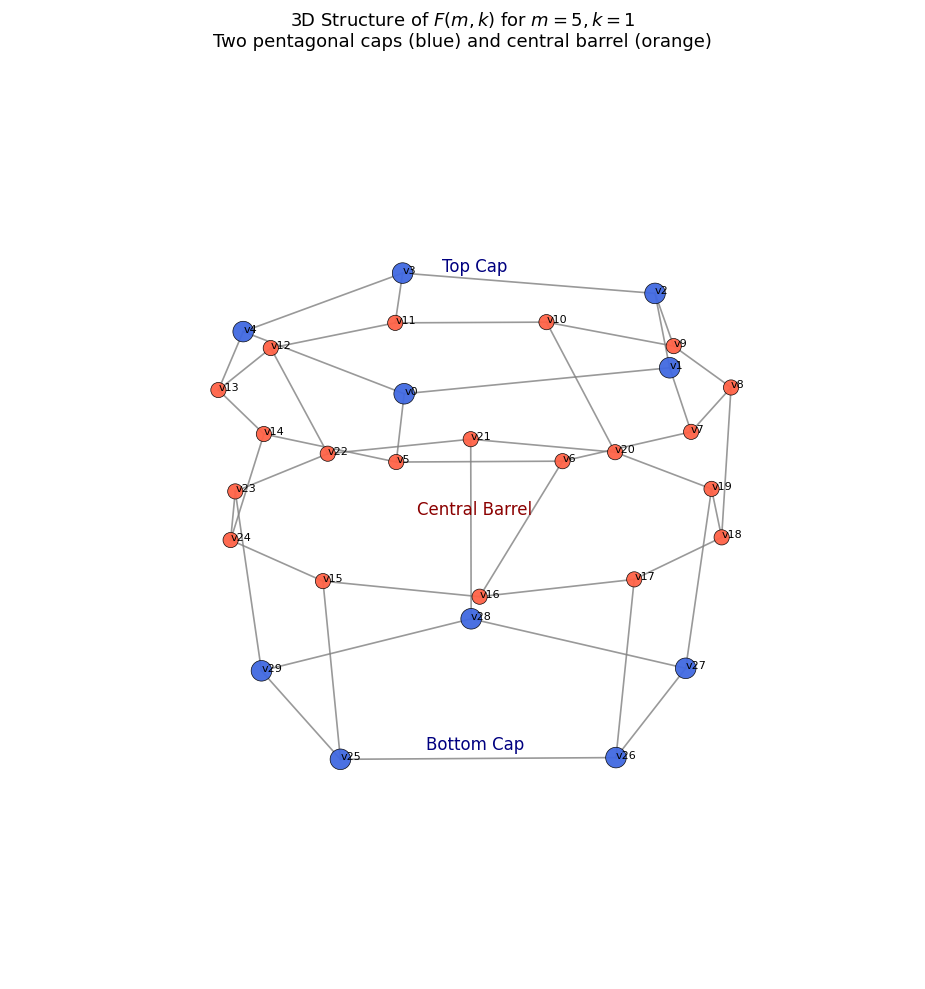

In [ ]:
"""
3D Visualization Tool for m-Generalized Fullerene Graphs F(m,k)

This script generates a 3D representation of the generalized fullerene graph structure.
It helps visualize the distinction between the pentagonal caps and the hexagonal barrel,
highlighting the specific topology discussed in the paper.

Reference:
    "The Forcing Matching Number of m-Generalized Fullerene Graphs"
    Authors: P. Asadzadeh, A. Behmaram, T. Doslic (2026)

Dependencies:
    networkx, numpy, matplotlib
"""

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, sqrt
from typing import Tuple, Dict, List

def construct_fmk_graph(m: int, k: int) -> Tuple[nx.Graph, List[int], List[int]]:
    """
    Constructs the F(m,k) graph and returns structure details.

    Args:
        m (int): Cap width.
        k (int): Barrel length.

    Returns:
        tuple: (Graph object, Layer start indices, Layer sizes)
    """
    if m < 3:
        raise ValueError("Parameter 'm' must be at least 3.")

    G = nx.Graph()

    # Define layer sizes: Cap(m) -> Barrel(2m) * (k+1) -> Cap(m)
    layer_sizes = [m] + [2 * m for _ in range(k + 1)] + [m]
    layer_starts = np.cumsum([0] + layer_sizes)[:-1]
    n_vertices = sum(layer_sizes)
    G.add_nodes_from(range(n_vertices))

    # 1. Create Cap Layers (Top and Bottom rings)
    for r in [0, k + 2]:
        start, size = layer_starts[r], layer_sizes[r]
        for c in range(size):
            G.add_edge(start + c, start + (c + 1) % size)

    # 2. Create Barrel Layers (Hexagonal rings)
    for r in range(1, k + 2):
        start, size = layer_starts[r], layer_sizes[r]
        for c in range(size):
            G.add_edge(start + c, start + (c + 1) % size)

    # 3. Inter-layer Connections
    # Top Cap -> First Barrel Layer
    first_middle_start = layer_starts[1]
    for c in range(m):
        pos = (2 * c) % (2 * m)
        G.add_edge(layer_starts[0] + c, first_middle_start + pos)

    # Barrel -> Barrel Connections
    for i in range(k):
        r = 1 + i
        start1, start2 = layer_starts[r], layer_starts[r + 1]
        connect_parity = 1 if r % 2 == 1 else 0
        for j in range(m):
            pos = (2 * j + connect_parity) % (2 * m)
            G.add_edge(start1 + pos, start2 + pos)

    # Last Barrel Layer -> Bottom Cap
    last_middle_start, last_r = layer_starts[k + 1], k + 1
    connect_parity = 1 if last_r % 2 == 1 else 0
    for c in range(m):
        pos = (2 * c + connect_parity) % (2 * m)
        G.add_edge(layer_starts[k + 2] + c, last_middle_start + pos)

    return G, layer_starts, layer_sizes

def calculate_3d_positions(m: int, k: int, layer_starts: List[int], layer_sizes: List[int]) -> Dict[int, Tuple[float, float, float]]:
    """
    Calculates 3D coordinates for vertices to visualize the cylindrical structure.
    """
    pos_3d = {}
    barrel_radius = m / pi  # Approximate radius to fit m-gons
    total_height = (k + 1) * sqrt(3)

    # Calculate Barrel Positions
    for r_idx in range(1, k + 2):
        start_node = layer_starts[r_idx]
        size = layer_sizes[r_idx]

        # Z-coordinate: centered around 0
        z = total_height / 2 - (r_idx - 1) * sqrt(3)

        # Phase shift for hexagonal tiling effect
        phase_shift = (pi / size) if (r_idx % 2 != 0) else 0

        for c in range(size):
            angle = 2 * pi * c / size + phase_shift
            x = barrel_radius * cos(angle)
            y = barrel_radius * sin(angle)
            pos_3d[start_node + c] = (x, y, z)

    # Calculate Top Cap Positions
    cap_height_offset = barrel_radius * 0.5
    z_cap_top = total_height / 2 + cap_height_offset

    for c in range(m):
        # Project from the connecting barrel nodes
        node_in_barrel = layer_starts[1] + (2 * c)
        x_barrel, y_barrel, _ = pos_3d[node_in_barrel]
        # Shrink radius slightly for visual effect
        pos_3d[c] = (x_barrel * 0.9, y_barrel * 0.9, z_cap_top)

    # Calculate Bottom Cap Positions
    z_cap_bottom = -total_height / 2 - cap_height_offset
    last_barrel_layer_r = k + 1
    connect_parity = 1 if last_barrel_layer_r % 2 != 0 else 0

    for c in range(m):
        node_in_barrel = layer_starts[k + 1] + (2 * c + connect_parity) % (2 * m)
        x_barrel, y_barrel, _ = pos_3d[node_in_barrel]
        pos_3d[layer_starts[k + 2] + c] = (x_barrel * 0.9, y_barrel * 0.9, z_cap_bottom)

    return pos_3d

def visualize_structure(m: int, k: int):
    """
    Main function to generate the 3D plot using Matplotlib.
    """
    # 1. Setup Data
    G, layer_starts, sizes = construct_fmk_graph(m, k)
    pos_3d = calculate_3d_positions(m, k, layer_starts, sizes)

    # Convert positions to numpy array for easier slicing
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])

    # 2. Define Visual Style (Colors & Sizes)
    color_map = []
    size_map = []

    top_cap_indices = range(0, layer_starts[1])
    bottom_cap_indices = range(layer_starts[k+2], len(G.nodes))

    for node in sorted(G):
        if node in top_cap_indices or node in bottom_cap_indices:
            color_map.append("royalblue")  # Caps color
            size_map.append(220)
        else:
            color_map.append("tomato")     # Barrel color
            size_map.append(120)

    # 3. Plotting
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Draw Edges
    for u, v in G.edges():
        x = [pos_3d[u][0], pos_3d[v][0]]
        y = [pos_3d[u][1], pos_3d[v][1]]
        z = [pos_3d[u][2], pos_3d[v][2]]
        ax.plot(x, y, z, color="gray", linewidth=1.2, alpha=0.6)

    # Draw Nodes
    ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2],
               s=size_map, c=color_map, edgecolors="k", linewidths=0.5, alpha=0.95)

    # Add Node Labels (Optional: good for small graphs like m=5)
    if m <= 6 and k <= 2:
        for node, (x, y, z) in pos_3d.items():
            ax.text(x, y, z, f"{node}", fontsize=8, color="black", zorder=10)

    # Add Annotations
    z_max = max(node_xyz[:, 2])
    z_min = min(node_xyz[:, 2])

    ax.text(0, 0, z_max + 1.0, "Top Cap", fontsize=14, color="navy", ha="center", fontweight='bold')
    ax.text(0, 0, z_min - 1.0, "Bottom Cap", fontsize=14, color="navy", ha="center", fontweight='bold')
    ax.text(0, 0, 0, "Central Barrel", fontsize=14, color="darkred", ha="center", fontweight='bold')

    # View Settings
    ax.view_init(elev=20, azim=45)
    ax.set_title(rf"3D Structure of $F(m,k)$ for $m={m}, k={k}$" "\n"
                 r"Highlighting Pentagonal Caps (Blue) vs Hexagonal Barrel (Orange)",
                 fontsize=15, pad=20)

    # Hide Axes for cleaner look
    ax.set_axis_off()

    print("Displaying 3D plot...")
    plt.tight_layout()
    plt.show()

# ==============================================================================
# Execution
# ==============================================================================
if __name__ == "__main__":
    # Example Parameters used in the paper's Figure 2
    M_PARAM = 5
    K_PARAM = 1

    visualize_structure(M_PARAM, K_PARAM)